In [1]:
from GradCam import GradCam

from torchvision import models as pretrained
from PIL import Image, ImageDraw

from typing import List, Union

import torch

from IPython.display import display
import numpy as np

In [12]:
class ImageClassificationGCWrapper:

    def __init__(self, models:List[torch.nn.Module], layers:List[torch.nn.Module], device, images:List[Image.Image], model_names:Union[List[str],None] = None):

        self.device = device
        assert len(models) == len(layers), "Same number of models and layers of interest should be provided"

        if model_names is None:
            self.model_names = [f"Model {i}" for i in range(len(models))]
        else:
            assert len(model_names) == len(models), "Same number of models and model names should be provided"
            self.model_names = model_names

        self.gradcams = [GradCam(m, l, self.device) for (m,l) in zip(models, layers)]
        self.images = images

    def evaluate(self, save=False):

        for i,image in enumerate(self.images):
            print("Baseline Image")
            display(image)
            heatmaps = [gc(image) for gc in self.gradcams]

            for hm, model_name in zip(heatmaps, self.model_names):
                ImageDraw.Draw(hm).text((0, 0), model_name, (255, 255, 255))

            heatmaps = Image.fromarray(np.hstack([np.array(hm) for hm in heatmaps]))

            if save:
                heatmaps.save(f"Heatmap{i}.png", 'PNG')
            else:
                display(heatmaps)

In [13]:
models = [
        pretrained.resnet50(pretrained=True), 
        pretrained.densenet121(pretrained=True), 
        pretrained.googlenet(pretrained=True), 
        pretrained.vgg19(pretrained=True)
    ]


layers = [
        models[0].layer4,
        models[1].features.denseblock4, 
        models[2].inception5b, 
        models[3].features[35]
    ]


images = [
        Image.open("Elephant.jpeg"), 
        Image.open("Tiger.jpg")
    ]
    
model_names = [
        "ResNet50", 
        "DenseNet121", 
        "GoogleNet", 
        "VGG19"
    ]


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [15]:
icgcw = ImageClassificationGCWrapper(models, layers, device, images, model_names)


Baseline Image


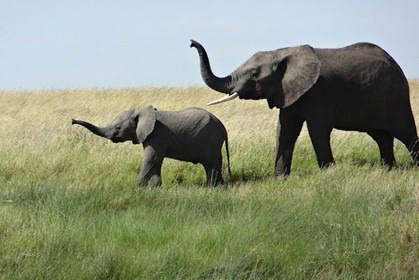

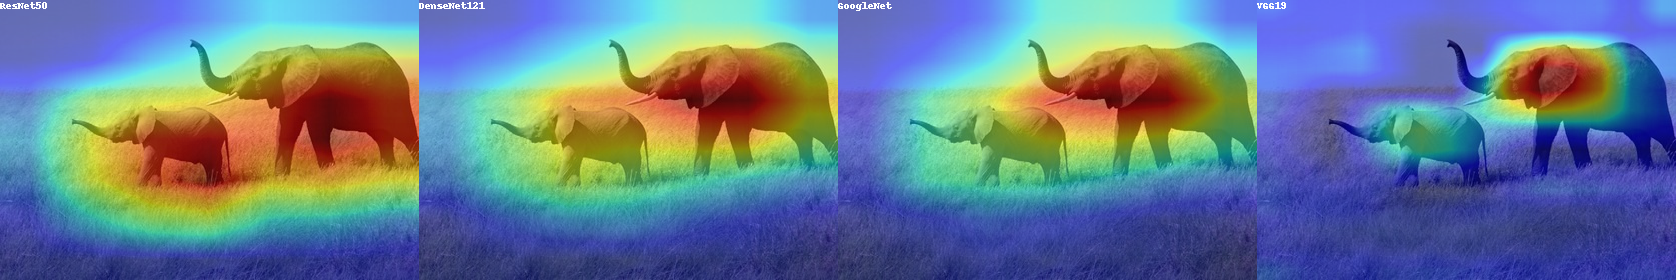

Baseline Image


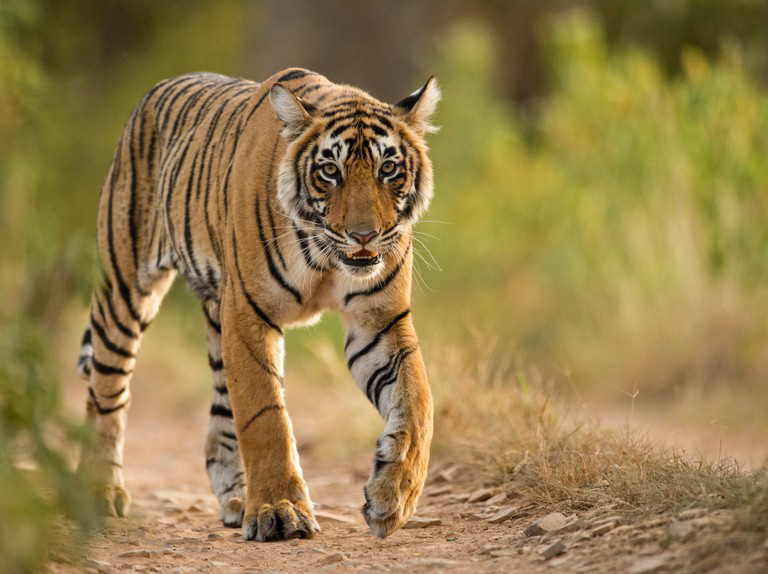

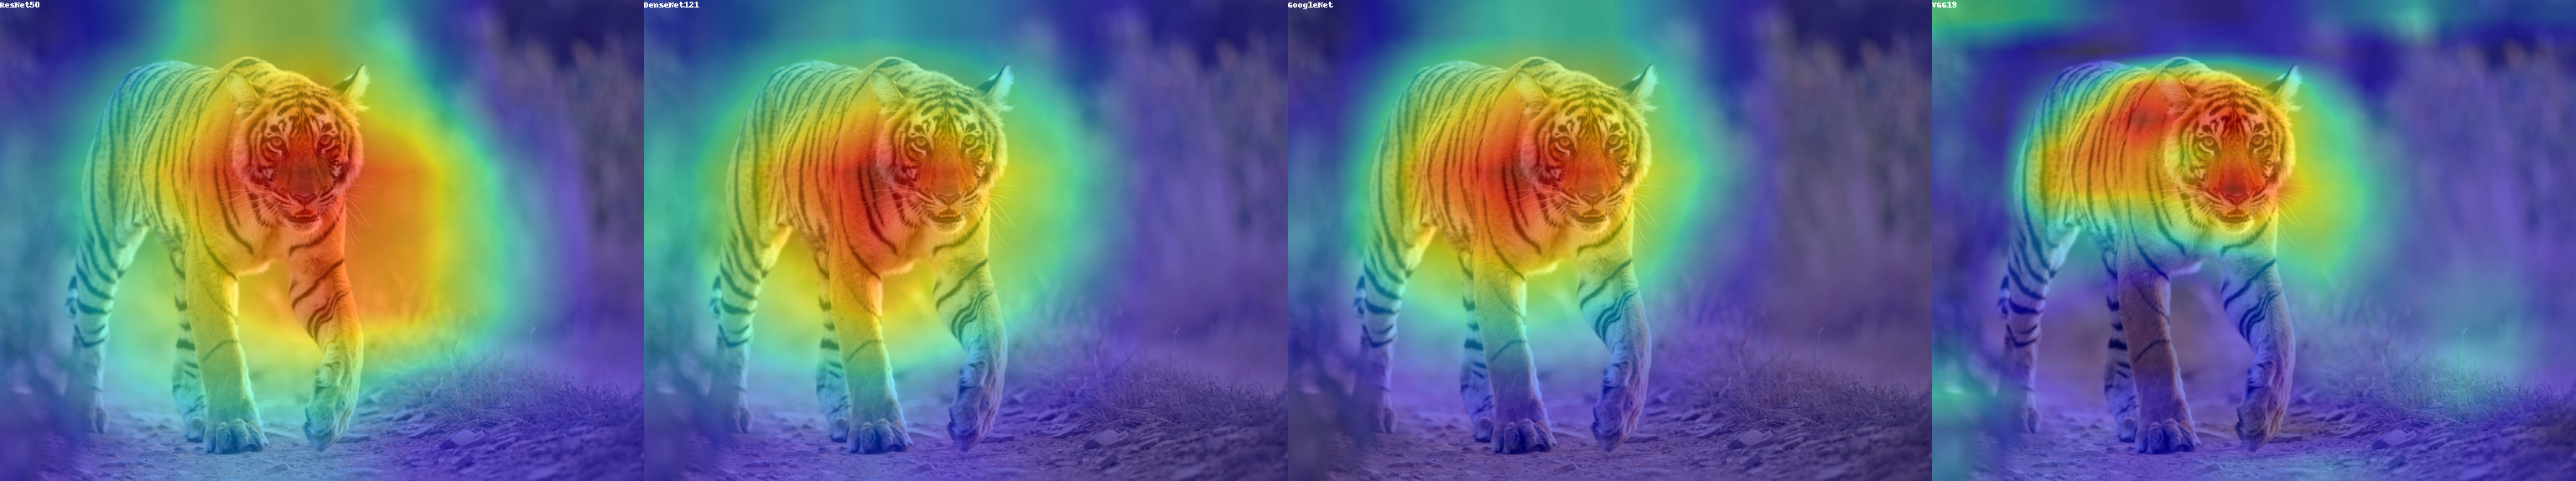

In [16]:
icgcw.evaluate()